In [139]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# feature engineering

In [140]:
df = pd.read_csv('./AllFeaturesDogMoveDataExtracted.csv')

In [141]:
# sum of triaxial SD for each sensor modality 
df['Axyz_SD'] = (df['Ax_Standard deviation'] + df['Ay_Standard deviation'] + df['Ax_Standard deviation'])
df['Gxyz_SD'] = (df['Gx_Standard deviation'] + df['Gy_Standard deviation'] + df['Gx_Standard deviation'])

# mean value (3 axes, 2 sensor modalities = 6 total)
# already included in dataframe (one of the default features to be extracted by tsfel)

# sum of triaxial zero crossing rate for each sensor modality
df['Axyz_ZCR'] = df['Ax_Zero crossing rate'] + df['Ay_Zero crossing rate'] + df['Az_Zero crossing rate']
df['Gxyz_ZCR'] = df['Gx_Zero crossing rate'] + df['Gy_Zero crossing rate'] + df['Gz_Zero crossing rate']

In [117]:
#df.iloc[114:118, -8:-6] # labels have some values between 0 and 1 where there was a transition of behavior, as shown here 

In [142]:
for col in ['Behavior_Lying_Mean', 'Behavior_Moving_Mean', 'Behavior_Sitting_Mean', 'Behavior_Standing_Mean']:
    df[col] = np.where(df[col] >= 0.5, 1, 0) # replace values >= 0.5 with 1, else 0 

In [119]:
#df.iloc[114:118, -8:-6] # confirm that the change has been made 

In [120]:
# # position offset: euclidean distance from robust mean (standing) - recalculate for each dogID
# # groupby DogID_Mean
# # where Behavior_Standing_Mean == 1
# # take 'robust mean' of standing dog 
# # euclidian distance from observation to mean of standing 

# df.groupby('DogID_Mean') 
# mean_standing = df.iloc[np.where(df['Behavior_Standing_Mean'] == 1)] # select only rows where dog is standing 
# mean_standing = mean_standing.iloc[:,[7,17,27,37,47,57,-5]] # select only gyro and acc columns + dog ID 
# height = pd.DataFrame() # height is the robust mean of standing for A and G  

# dict = np.unique(mean_standing['DogID_Mean']) # unique dog IDs
# dict2 = np.unique(df['DogID_Mean']) # unique dog IDs
# print(len(dict), len(dict2),'\n', dict2) # found a dog that never stood up! 


# # compare filtered dataset to unmodified dataset to work out how many dogs are missing 
# # take one value from the other to get the number of missing entries (n)
# # assign (n) new values to dataset and impute mean values 

# for x in dict: # iterate over individual dogs 
#     temp = mean_standing.iloc[np.where(mean_standing['DogID_Mean'] == x)] # temp df where DogID == dog (x) 
#     avg = temp.mean() # take mean of standing for that dog 
#     height = height.append({'DogID':x,'Axyz_Mean_Standing':[avg[0],avg[1], avg[2]], 'Gxyz_Mean_Standing':[avg[3], avg[4], avg[5]]}, ignore_index=True) # add mean of standing for each dog to a new df

# height = height.append({'DogID':58.0,'Axyz_Mean_Standing':[0.1,0.1,0.1], 'Gxyz_Mean_Standing':[0.1,0.1,0.1]}, ignore_index=True) 
# # impute Axyz & Gxyz values for missing dog 

In [121]:
# appendL = []
# def eucildean_calculator(df, i, j): 
#     heightTable = (height.loc[height["DogID"] == float(df[-5])]) # match dogIDs
#     A = heightTable["Axyz_Mean_Standing"] 
#     G = heightTable["Gxyz_Mean_Standing"]
#     windowA = np.array(df[i]) # create array of sensor axis values 
#     windowG = np.array(df[j])   
#     retA = np.linalg.norm(np.array(A)[0] - windowA) # calculate position offset (euclidean distance from mean of standing)
#     retG = np.linalg.norm(np.array(G)[0] - windowG) 
#     appendL.append([retA, retG]) # append position offset values to empty list 

# out = np.apply_along_axis(eucildean_calculator, 1, df, [7,17,27], [37,47,57]) # apply function along axis. [7,17,27], [37,47,57] indicate columns from which to create window vector 
# appendL = pd.DataFrame(appendL, columns=["APO", "GPO"]) # APO = Acc. pos ofset
# df = pd.concat([df, appendL], axis=1) # aggregate pos ofset values to main dataframe
# df.head()

In [122]:
# # drop axis SD features since we have already calculated their sum with Axyz_SD and Gxyz_SD
# # also drop axis ZCR since we have calculated their sum also 
# df.drop(columns=['Ax_Standard deviation', 'Ay_Standard deviation', 'Az_Standard deviation', 'Gx_Standard deviation', 'Gy_Standard deviation', 'Gz_Standard deviation',
# 'Ax_Zero crossing rate', 'Ay_Zero crossing rate', 'Az_Zero crossing rate', 'Gx_Zero crossing rate', 'Gy_Zero crossing rate', 'Gz_Zero crossing rate'], inplace=True)

# exploring the data with some plots

In [144]:
# # reverse dummy encoding behavior labels for plotting purposes. then rename 
df['Behavior'] = (df.iloc[:, -9:-5] == 1).idxmax(1)
df['Behavior'].replace({'Behavior_Moving_Mean':'Moving', 'Behavior_Lying_Mean':'Lying', 'Behavior_Sitting_Mean':'Sitting', 'Behavior_Standing_Mean':'Standing'}, inplace=True)

In [145]:
np.unique(df['Behavior'])

array(['Lying', 'Moving', 'Sitting', 'Standing'], dtype=object)

In [124]:
# sns.countplot(x='Behavior', data=df)
# plt.show()
# class imbalance is clear ! many more moving samples than static 

In [125]:
# plot total activity (sum SD) by behavior 
# fig, ax = plt.subplots(1,2)
# fig.set_size_inches(14, 5)
# sns.boxplot(x='Behavior', y="Axyz_SD", data=df, ax=ax[0])
# sns.boxplot(x='Behavior', y="Gxyz_SD", data=df, ax=ax[1])

# dynamic behavior associated with a greater range in total activity (sum SD), as one might expect 

In [126]:
# fig, ax = plt.subplots(1,2)
# fig.set_size_inches(14, 5)
# sns.boxplot(x='Behavior', y="Axyz_ZCR", data=df, ax=ax[0])
# sns.boxplot(x='Behavior', y="Gxyz_ZCR", data=df, ax=ax[1])

# appears that sum(ZCR) from accelerometer doesnt tell the same story as sum(ZCR) from gyroscope! 


In [127]:
# fig, ax = plt.subplots(1,2)
# fig.set_size_inches(14, 5)
# sns.boxplot(x='Behavior', y="APO", data=df, ax=ax[0])
# sns.boxplot(x='Behavior', y="GPO", data=df, ax=ax[1])

# similarly, acc & gyro position offset seems to have a wider and slightly higher range for dynamic behavior than static 

In [146]:
# before we move onto feature selection, we can remove any rows where behaviour = Standing. This label was included up to this point to enable to calculation of a mean of standing for each dog, which was a prerequsite for the calculation of the feature position offset (APO, GPO) 
# now that APO & GPO have been calculated and added to the dataframe, we can drop behavior=Standing rows 

df = df[~df['Behavior'].isin(['Standing'])] # drop rows where behavior == standing 

# feature selection
* univariate selection with ANOVA (f_classif)
* ExtraTreesClassifier 

In [147]:
# cols = list(df.columns.values) # rearrange column order to make slicing easier 
# df = df[['Ax_ECDF Percentile_0', 'Ax_ECDF Percentile_1', 'Ax_ECDF Percentile_2', 'Ax_ECDF Percentile_3', 'Ax_ECDF Percentile_4', 'Ax_ECDF Percentile_5', 'Ax_ECDF Percentile_6', 'Ax_Mean', 'Ay_ECDF Percentile_0', 'Ay_ECDF Percentile_1', 'Ay_ECDF Percentile_2', 'Ay_ECDF Percentile_3', 'Ay_ECDF Percentile_4', 'Ay_ECDF Percentile_5', 'Ay_ECDF Percentile_6', 'Ay_Mean', 'Az_ECDF Percentile_0', 'Az_ECDF Percentile_1', 'Az_ECDF Percentile_2', 'Az_ECDF Percentile_3', 'Az_ECDF Percentile_4', 'Az_ECDF Percentile_5', 'Az_ECDF Percentile_6', 'Az_Mean', 'Gx_ECDF Percentile_0', 'Gx_ECDF Percentile_1', 'Gx_ECDF Percentile_2', 'Gx_ECDF Percentile_3', 'Gx_ECDF Percentile_4', 'Gx_ECDF Percentile_5', 'Gx_ECDF Percentile_6', 'Gx_Mean', 'Gy_ECDF Percentile_0', 'Gy_ECDF Percentile_1', 'Gy_ECDF Percentile_2', 'Gy_ECDF Percentile_3', 'Gy_ECDF Percentile_4', 'Gy_ECDF Percentile_5', 'Gy_ECDF Percentile_6', 'Gy_Mean', 'Gz_ECDF Percentile_0', 'Gz_ECDF Percentile_1', 'Gz_ECDF Percentile_2', 'Gz_ECDF Percentile_3', 'Gz_ECDF Percentile_4', 'Gz_ECDF Percentile_5', 'Gz_ECDF Percentile_6', 'Gz_Mean', 'Axyz_SD', 'Gxyz_SD', 'Axyz_ZCR', 'Gxyz_ZCR', 'APO', 'GPO', 'Behavior_Lying_Mean', 'Behavior_Moving_Mean', 'Behavior_Sitting_Mean', 'Behavior_Standing_Mean', 'DogID_Mean', 'Behavior']]

# dummy encoded behaviour labels were needed for feature extraction but not for classification. hence we can drop them 
df.drop(columns=['Behavior_Lying_Mean', 'Behavior_Moving_Mean', 'Behavior_Sitting_Mean', 'Behavior_Standing_Mean'], inplace=True)

In [148]:
y = df['Behavior']
x = df.iloc[:,:-2]

skb_model = SelectKBest(f_classif, k=14) # anova feature selection - modify k here 
skb_model.fit(x, y)

features = skb_model.fit_transform(x,y) # identify k best features 
skb_top_n_features_ind = skb_model.get_support(indices=True) # index these features 
fsel = x.iloc[:,skb_top_n_features_ind] 

features_ranked = pd.DataFrame({'col_name': skb_model.scores_}, index=x.columns).sort_values(by='col_name', ascending=False)

skb_top_n_features_ind


array([ 253,  396,  416,  422,  424,  425,  488,  631,  652,  655,  657,
        659,  958, 1193])

<AxesSubplot:title={'center':'ranked feature importance scores from SelectKBest ANOVA test'}>

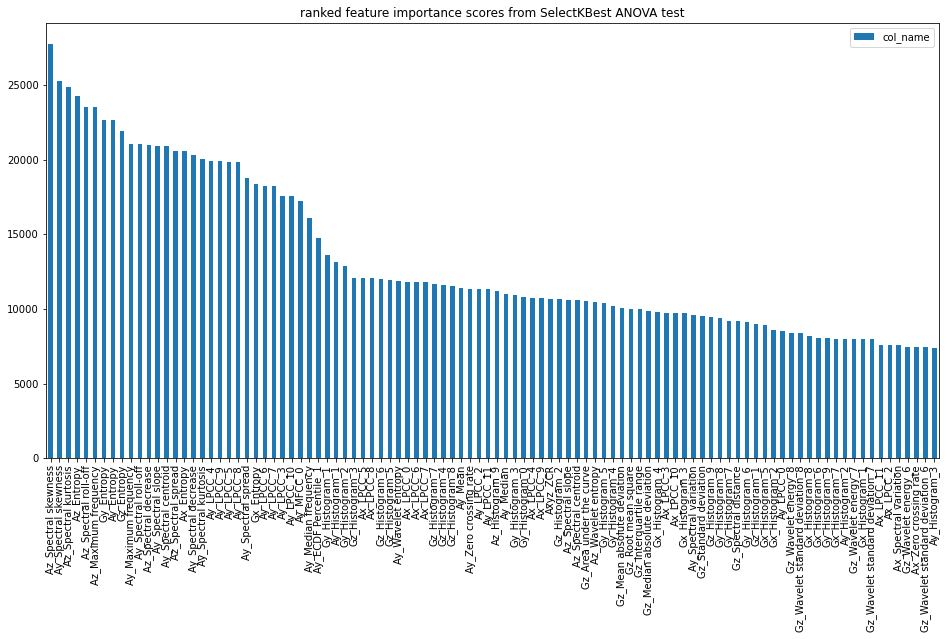

In [149]:
features_ranked.iloc[:100,:].plot(kind='bar', figsize=(16,8), title='ranked feature importance scores from SelectKBest ANOVA test')
# diminishing returns after k=9, k=22, k=34

In [150]:
y = df['Behavior']
x = df.iloc[:,:-2]

# feature selection with extra trees classifier 
etc_model = ExtraTreesClassifier(n_estimators=100)
etc_model.fit(x, y)

features_ranked = pd.DataFrame({'col_name': etc_model.feature_importances_}, index=x.columns).sort_values(by='col_name', ascending=False)

etc_top_n_features = features_ranked.iloc[:5,:] # modify n here 
cols = list(etc_top_n_features.index.values) 
etc_top_n_features_ind = [df.columns.get_loc(c) for c in cols if c in df]

<AxesSubplot:title={'center':'ranked feature importance scores from ExtraTreesClassifier'}>

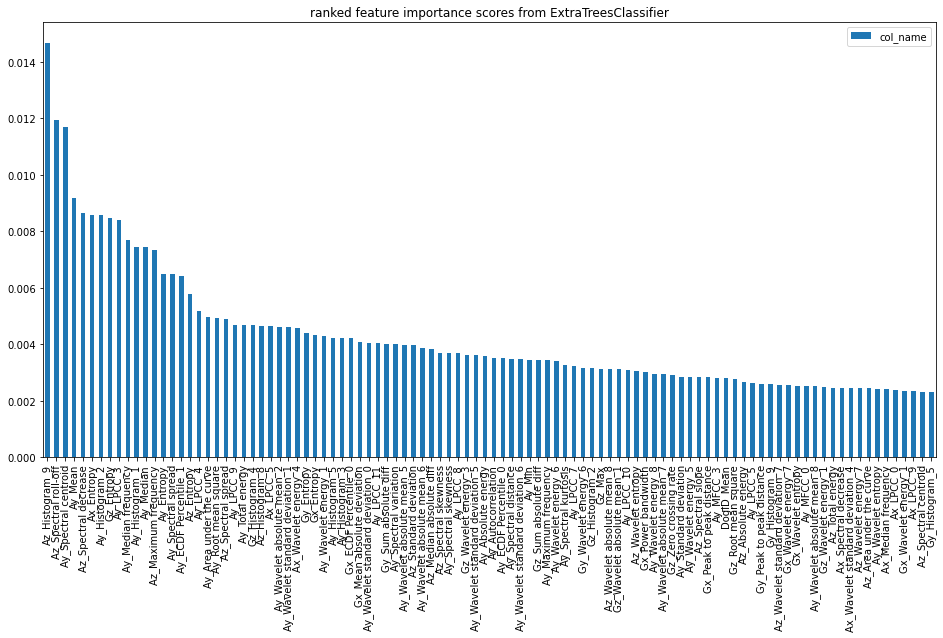

In [151]:
features_ranked.iloc[:100, :].plot(kind='bar', figsize=(16,8), title='ranked feature importance scores from ExtraTreesClassifier')
# diminishing returns after 5th, 10th feature 

In [152]:
x_top_n = df.iloc[:,etc_top_n_features_ind] # modify feature selection algorithm here 
y = df['Behavior']

*FEATURE SELECTED (X_TOP_N) DATA IS NORMALISED BELOW AND REASSIGNED = X_TOP_N_NORM*

In [153]:
# feature normalisation 
scaler = preprocessing.StandardScaler()
x_top_n_norm = scaler.fit_transform(x_top_n)

# model building!  
* simple train_test_split for preliminary model building
* followed by leave-one-group-out cross-validation (dog-wise) 

In [154]:
x_train, x_test, y_train, y_test = train_test_split(x_top_n_norm, y, test_size=0.2)

* Kumpulainena et al., (2021) used four models:
    * linear and quadratic discriminant analysis classifiers (LDA and QDA, respectively)
    * support vector machine (SVM) classifier with gaussian kernel 
    * a classification (decision) tree
* regarding evaluation metrics for the models, we will use the following:
    * f1 score - robust evaluation method, useful where there is a class imbalance as is present here
    * confusion matrix - indicates false positives and false negatives 

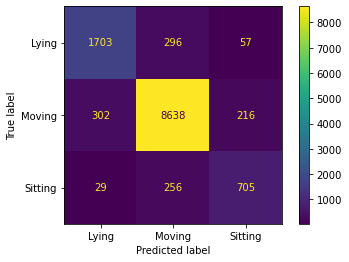

accuracy = 0.9052614325520406
f1-score = [0.83276284 0.94167666 0.71646341]


In [155]:
# training a DescisionTreeClassifier
dtc_model = DecisionTreeClassifier(max_depth = 18).fit(x_train, y_train)
dtc_preds = dtc_model.predict(x_test)

# accuracy score  
accuracy = dtc_model.score(x_test, y_test)

# creating a confusion matrix
cm = confusion_matrix(y_test, dtc_preds, labels=dtc_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20)=0.815 // etc_model(9)=0.811 // skb_model(14)=0.803 - custom features 
                                # etc_model(5)=0.858 - default features 
print(f'f1-score = {f1_score(y_test, dtc_preds, average=None)}')

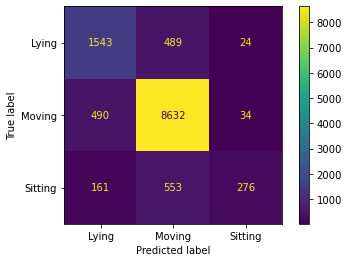

accuracy = 0.8564989346008851
f1-score = [0.72611765 0.91683484 0.41691843]


In [156]:
# support vector classifier 
svc_model = SVC(kernel = 'linear', C = 1).fit(x_train, y_train)
svc_preds = svc_model.predict(x_test)
 
# model accuracy for x_test 
accuracy = svc_model.score(x_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, svc_preds, labels=svc_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20) = 0.843 // etc_model(9)=0.817 // skb_model(14)=0.838 - custom features 
                                # etc_model(5)=0.838 - default features 
print(f'f1-score = {f1_score(y_test, svc_preds, average=None)}')

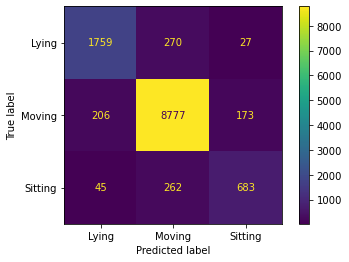

accuracy = 0.9194394361580068
f1-score = [0.86522381 0.95066342 0.72931127]


In [157]:
# k nearest neighbours
knn_model = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train)
knn_preds = knn_model.predict(x_test) 

# accuracy on x_test
accuracy = knn_model.score(x_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, knn_preds, labels=knn_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20) = 0.959 // etc_model(9)=0.946 // skb_model(14)=0.938 - custom features 
                                # etc_model(5)=0.938 - default features 
print(f'f1-score = {f1_score(y_test, knn_preds, average=None)}')

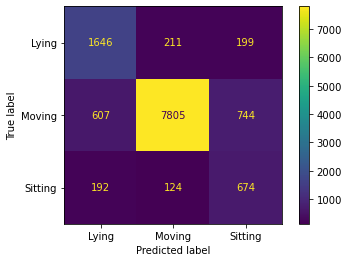

accuracy = 0.829782002950336
f1-score = [0.73139302 0.90252081 0.51706943]


In [158]:
# naive bayes (gaussian)
gnb_model = GaussianNB().fit(x_train, y_train)
gnb_preds = gnb_model.predict(x_test)
 
# accuracy on x_test
accuracy = gnb_model.score(x_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, gnb_preds, labels=gnb_model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gnb_model.classes_)
cmp.plot()
plt.show()

print(f'accuracy = {accuracy}') # etc_model(20) = 0.803 // etc_model(9)=0.799 // skb_model(14)=0.820 - custom features 
                                # etc_model(5)=0.820 - default features 
print(f'f1-score = {f1_score(y_test, gnb_preds, average=None)}')

# leave one (dog) out cross-validation 
* abrogates subject bias 

In [159]:
# groups = df['DogID_Mean'].values
# logo = LeaveOneGroupOut()
# logo.get_n_splits(x_20, y, groups=groups) # verify that there is a split for each dog (total 45) 

# for train_ind, test_ind in logo.split(x_20, y, groups=groups):
#     x_20_train = x_20.iloc[train_ind]
#     x_20_test = x_20.iloc[test_ind]
#     y_train = y.iloc[train_ind]
#     y_test = y.iloc[test_ind]